# Przygotowanie środowiska

In [1]:
# w przypadku korzystania z kernela Python
from pyspark.sql import SparkSession

In [2]:
# w przypadku korzystania z kernela Python
# w przypadku korzystania z klastra Hadoop
spark = SparkSession.builder.appName('SparkML-zadania').master("yarn").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/26 18:21:41 INFO SparkEnv: Registering MapOutputTracker
24/12/26 18:21:41 INFO SparkEnv: Registering BlockManagerMaster
24/12/26 18:21:41 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/12/26 18:21:41 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
spark

# Regresja liniowa

Na początku spróbujmy zbudować model, który pozwoli nam szacować ceny domów w Sydney. 

## Zapoznanie się ze zbiorem danych

Na początku zaczytajmy nasz zbiór danych, oraz zapoznajmy się z jego strukturą.

In [4]:
%%sh
wget https://jankiewicz.pl/bigdata/bigdata-sp/SydneyHousePrices.csv

--2024-12-26 18:21:49--  https://jankiewicz.pl/bigdata/bigdata-sp/SydneyHousePrices.csv
Resolving jankiewicz.pl (jankiewicz.pl)... 109.95.159.1
Connecting to jankiewicz.pl (jankiewicz.pl)|109.95.159.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11606169 (11M) [application/octet-stream]
Saving to: ‘SydneyHousePrices.csv.4’

     0K .......... .......... .......... .......... ..........  0% 1.15M 10s
    50K .......... .......... .......... .......... ..........  0% 2.31M 7s
   100K .......... .......... .......... .......... ..........  1%  119M 5s
   150K .......... .......... .......... .......... ..........  1% 2.37M 5s
   200K .......... .......... .......... .......... ..........  2%  130M 4s
   250K .......... .......... .......... .......... ..........  2%  115M 3s
   300K .......... .......... .......... .......... ..........  3%  160M 3s
   350K .......... .......... .......... .......... ..........  3% 2.44M 3s
   400K .......... .......... ......

In [5]:
%%sh
# w przypadku korzystania z klastra Hadoop
hadoop fs -mkdir -p .

In [6]:
%%sh
# w przypadku korzystania z klastra Hadoop
hadoop fs -copyFromLocal -f SydneyHousePrices.csv

In [7]:
sydneyHousePricesDF = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .load("SydneyHousePrices.csv")

In [8]:
sydneyHousePricesDF.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Id: integer (nullable = true)
 |-- suburb: string (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- sellPrice: integer (nullable = true)
 |-- bed: double (nullable = true)
 |-- bath: integer (nullable = true)
 |-- car: double (nullable = true)
 |-- propType: string (nullable = true)



Zobaczmy te dane

In [9]:
sydneyHousePricesDF.describe().toPandas()

,summary,Id,suburb,postalCode,sellPrice,bed,bath,car,propType
0,count,199504,199504,199504,199504,199350,199504,181353,199504
1,mean,99752.5,None,2196.379155305157,1269776.2961945625,3.5164785553047406,1.8906688587697489,1.936223828665641,None
2,stddev,57591.98838958998,None,193.05346728623104,6948239.273647814,1.0665549825968743,0.9260006352703465,1.060237335239494,None
3,min,1,Abbotsbury,2000,1,1.0,1,1.0,acreage
4,max,199504,Zetland,4878,2147483647,99.0,99,41.0,warehouse


In [10]:
print(f"""Correlation between "postalCode","sellPrice": {sydneyHousePricesDF.stat.corr("postalCode","sellPrice")}""")
print(f"""Correlation between "bed","sellPrice": {sydneyHousePricesDF.stat.corr("bed","sellPrice")}""")
print(f"""Correlation between "bath","sellPrice": {sydneyHousePricesDF.stat.corr("bath","sellPrice")}""")
print(f"""Correlation between "car","sellPrice": {sydneyHousePricesDF.stat.corr("car","sellPrice")}""")

Correlation between "postalCode","sellPrice": -0.042751539275178135
Correlation between "bed","sellPrice": 0.04193176878925137
Correlation between "bath","sellPrice": 0.056380688568675
Correlation between "car","sellPrice": 0.026340816601752623


In [11]:
sydneyHousePricesDF.sample(0.05).createOrReplaceTempView("sydneyHousePricesDF")

<AxesSubplot:xlabel='bed'>

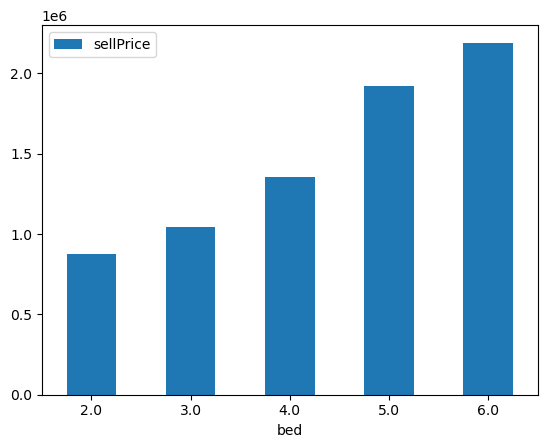

In [12]:
df = spark.sql("""select bed, avg(sellPrice) sellPrice 
    from sydneyHousePricesDF 
    group by bed 
    having count(*) > 100 
    order by bed """).toPandas()
df.plot.bar(x='bed', y='sellPrice', rot=0)

<AxesSubplot:xlabel='bath'>

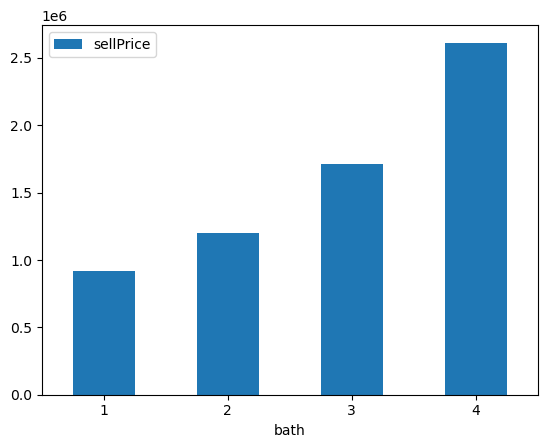

In [13]:
df = spark.sql("""select bath, avg(sellPrice) sellPrice 
    from sydneyHousePricesDF 
    group by bath 
    having count(*) > 100 
    order by bath """).toPandas()
df.plot.bar(x='bath', y='sellPrice', rot=0) 

<AxesSubplot:xlabel='bed'>

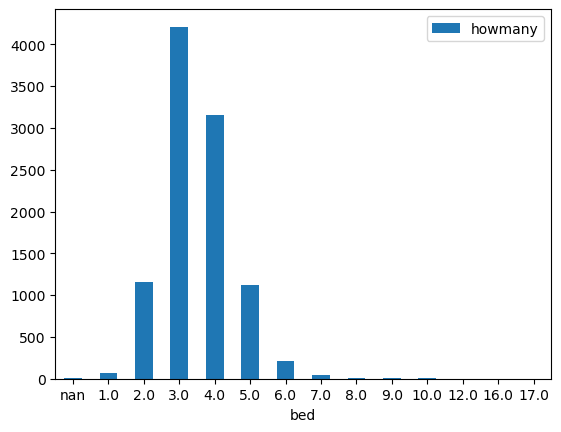

In [14]:
df = spark.sql("""select bed, count(*) as howmany 
    from sydneyHousePricesDF 
    group by bed 
    order by bed """).toPandas()
df.plot.bar(x='bed', y='howmany', rot=0) 

<AxesSubplot:xlabel='bath'>

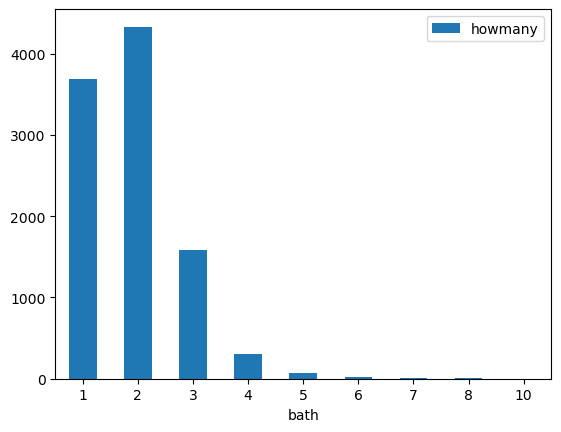

In [15]:
df = spark.sql("""select bath, count(*) as howmany 
    from sydneyHousePricesDF 
    group by bath 
    order by bath""").toPandas()
df.plot.bar(x='bath', y='howmany', rot=0) 

Przygotowanie danych dla algorytmów uczenia maszynowego, nie polega tylko na sprowadzeniu ich do odpowiedniego formatu, czy dostosowaniu przestrzeni cech (np. poprzez redukcję wymiarów).

Polega to także na oczyszczeniu tych danych. Bez tego etapu wyuczony model może okazać się bezużyteczny. 

Jak widać na powyższych wykresach, że mamy wiele danych odstających. Spróbujemy się ich pozbyć. 

In [16]:
cols_tmp = map(
    lambda t: t[0],
    filter(lambda t: 
           (t[1] == "double") or (t[1] == "int"),
           sydneyHousePricesDF.dtypes)
    )
list(cols_tmp)

['Id', 'postalCode', 'sellPrice', 'bed', 'bath', 'car']

In [17]:
cols = ["sellPrice", "bed", "bath", "car"]
cols

['sellPrice', 'bed', 'bath', 'car']

In [18]:
rd_rg = sydneyHousePricesDF.stat.approxQuantile(cols, [0.25, 0.75], 0.02)
rd_rg

[[705000.0, 1430000.0], [3.0, 4.0], [1.0, 2.0], [1.0, 2.0]]

In [19]:
min_max = list(
    map(
        lambda p : [p[0] - 1.5 * (p[1] - p[0]), 
                    p[1] + 1.5 * (p[1] - p[0])],
        rd_rg)
)
min_max

[[-382500.0, 2517500.0], [1.5, 5.5], [-0.5, 3.5], [-0.5, 3.5]]

In [20]:
exprs = " and ".join(
    map(
        lambda p : "`" + str(p[0]) + "` between " + 
                str(p[1][0]) + " and " + str(p[1][1]),
        zip (cols, min_max)
    )
)

exprs

'`sellPrice` between -382500.0 and 2517500.0 and `bed` between 1.5 and 5.5 and `bath` between -0.5 and 3.5 and `car` between -0.5 and 3.5'

In [21]:
sydneyHousePricesDF2 = sydneyHousePricesDF.where(exprs)

In [22]:
sydneyHousePricesDF.count()

199504

In [23]:
sydneyHousePricesDF2.count()

152390

Nasza analiza zależności pomiędzy danymi powinna być oczywiście bardziej dokładna. Oczyszczanie danych, być może bardziej zaawansowana obsługa danych odstających, to wszystko powinno tu mieć miejsce. 
My się tym jednak nie będziemy zajmować teraz. Możesz to zrobić w późniejszym etapie w ramach poprawy tej procedury. 

Teraz przejdźmy już bez dalszych opóźnień do naszej regresji liniowej.


## Dostosowanie formatu danych
Obecny format naszego `DataFrame` nie bardzo pasuje do formatu oczekiwanego przez mechanizmy biblioteki `MLlib`. Zatem w kolejnych krokach dokonamy stosownych transformacji. Skorzystamy w tym celu z klasy `VectorAssembler`. 
Poniżej znajdziesz przykład, który być może już gdzieś widziałeś:

```python
data = rawData.where("ibu is not null").\
              filter("style in ('American IPA','American Pale Ale (APA)','Kölsch')").\
              selectExpr("cast(ibu as int) ibu", 
                         "cast(abv*100 as float) abv",
                         "style as label")

assembler = VectorAssembler(
    inputCols=["ibu", "abv"],
    outputCol="features")

df = assembler.transform(data)
```

Na początek utwórz obiekt przypisany do nazwy `data` klasy `DataFrame`, który będzie przygotowywał podstawową wersję danych

Kilka wskazówek:
- chcemy wykorzystywać kolumnę `suburb`, z kodu pocztowego zrezygnujemy - pamiętaj jednak, że to regresja liniowa i własności muszą być numeryczne...
- `propType` jest ważny, jednak jak być może wiesz, cechy będące ciągami znaków nie są wspierane - problem jak wyżej
- pamiętaj aby wskazać etykietę - musi być typu `double`
- poniżej oczekiwany wynik funkcji `printSchema()`
- koniecznie usuń te dane, w których pojawiają się wartości puste

***Zadanie 1***

In [24]:
from pyspark.sql.functions import col,expr

# Zamiana suburb na wartości liczbowe
suburbAsNumber = \
    spark.sql("""select suburb, avg(sellPrice) as avg_price, 
    row_number() over (order by avg(sellPrice)) as suburb_nr 
    from sydneyHousePricesDF 
    group by suburb """)

# Zamiana propType na wartości liczbowe
propTypeAsNumber = \
    spark.sql("""select propType, avg(sellPrice) as avg_price, 
    row_number() over (order by avg(sellPrice)) as propType_nr 
    from sydneyHousePricesDF 
    group by propType """)

# Przygotowanie danych
data = sydneyHousePricesDF2.na.drop().\
    join(suburbAsNumber, "suburb").\
    join(propTypeAsNumber, "propType").\
    select(
        col("suburb"), col("suburb_nr"), 
        col("bed"), col("bath"), col("car"), 
        col("propType"), col("propType_nr"), 
        expr("CAST(sellPrice as DOUBLE) as label")
    )


data.printSchema()

root
 |-- suburb: string (nullable = true)
 |-- suburb_nr: integer (nullable = false)
 |-- bed: double (nullable = true)
 |-- bath: integer (nullable = true)
 |-- car: double (nullable = true)
 |-- propType: string (nullable = true)
 |-- propType_nr: integer (nullable = false)
 |-- label: double (nullable = true)



```
root
 |-- suburb: string (nullable = true)
 |-- suburb_nr: integer (nullable = true)
 |-- bed: double (nullable = true)
 |-- bath: integer (nullable = true)
 |-- car: double (nullable = true)
 |-- propType: string (nullable = true)
 |-- propType_nr: integer (nullable = true)
 |-- label: double (nullable = true)
```

Teraz już z górki. 

In [25]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(\
    inputCols=["suburb_nr", "bed", "bath", "car", "propType_nr"],\
    outputCol="features")

sydneyHPLibSVMDF = assembler.transform(data)
sydneyHPLibSVMDF.printSchema()

root
 |-- suburb: string (nullable = true)
 |-- suburb_nr: integer (nullable = false)
 |-- bed: double (nullable = true)
 |-- bath: integer (nullable = true)
 |-- car: double (nullable = true)
 |-- propType: string (nullable = true)
 |-- propType_nr: integer (nullable = false)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



Aby w przyszłości nie dokonywać tego za każdym razem, wynik tych transformacji zapiszemy w formacie `LIBSVM`

`LIBSVM` to jedna z popularnych bibliotek przeznaczona (jak sama nazwa wskazuje) dla algorytmów klasyfikacji metodą wektorów nośnych.
Format danych `libsvm` jest specyficznym formatem dla tej właśnie biblioteki, ale że przechowuje dane w postaci
`<label> <index1>:<value1> <index2>:<value2>`
może być wykorzystywany w praktycznie nieograniczonym zakresie przypadków. 


Patrz: https://spark.apache.org/docs/latest/ml-datasource.html

In [26]:
%%sh
# w przypadku korzystania z klastra Hadoop
hadoop fs -rm -r -f sydneyHPLibSVMDF

Deleted sydneyHPLibSVMDF


In [27]:
dataDF = sydneyHPLibSVMDF.select(col("label"),col("features"))
dataDF.write.format("libsvm").save("sydneyHPLibSVMDF")

24/12/26 18:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

Uwaga! `libsvm` wymaga ściśle określonej struktury. Jeśli będziemy chcieli pobierać poźniej taki plik musimy się nauczyć funkcjonować z typem `Vector`. 

Patrz późniejsze funkcje. 

Jeśli potrzebujemy dokonać tylko jednorazowo takiego przetworzenia, możemy w dalszym etapie przetwarzać `DataFrame` tylko uzupełniony o `features` i `label`

## Wyliczenie modelu 

Na początku podzielmy nasz zbiór na zbiór uczący i testowy

In [28]:
(trainingDF, testDF) = dataDF.randomSplit([0.7, 0.3], seed = 1234)

Utwórzmy definicję naszego algorytmu regresji

In [29]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

 

Utwórzmy nasz model wykorzystując do tego zbioru danych uczących

In [30]:
lrModel = lr.fit(trainingDF)

24/12/26 18:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:22:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

In [31]:
# Wyświetlmy współczynniki (coefficients) 
# oraz punkt przecięcia (intercept) naszego modelu
print(f"Coefficients: {lrModel.coefficients} Intercept: {lrModel.intercept}")

Coefficients: [1997.8288007192396,81224.99434207036,66843.7609406117,29608.260736739136,50694.81338549419] Intercept: -255848.53578252663


In [32]:
# Pobierzmy kilka dodatkowych metryk i podsumowań dotyczących naszego modelu 
trainingSummary = lrModel.summary
print(f"numIterations: {trainingSummary.totalIterations}")
print(f"objectiveHistory: {str(trainingSummary.objectiveHistory)}")
trainingSummary.residuals.show(10)
print(f"RMSE: {trainingSummary.rootMeanSquaredError}")
print(f"r2: {trainingSummary.r2}")

numIterations: 10
objectiveHistory: [0.5000000000000004, 0.4172825123008226, 0.2738015032596712, 0.23297835410461717, 0.22250598435079721, 0.21982412342301977, 0.2189663760189053, 0.21890528951387997, 0.2188805683219771, 0.21886141679692125, 0.21886044284847955]


24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

+-------------------+
|          residuals|
+-------------------+
|-1431183.2359648524|
|-1431183.2359648524|
| -1747755.596995369|
| -1747754.596995369|
|-1604860.3416274264|
| -711825.6149505173|
| -711660.6149505173|
| -717878.5253821333|
| -548637.0832982394|
|  -675527.716027394|
+-------------------+
only showing top 10 rows

RMSE: 313791.1438353113
r2: 0.5622815506445634


## Predykcja i ewaluacja

Wyliczmy predykcje cen dla testowego zbioru danych

In [33]:
predictions = lrModel.transform(testDF)

predictions.show(10)

24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

+------+--------------------+------------------+
| label|            features|        prediction|
+------+--------------------+------------------+
|   1.0|[330.0,5.0,2.0,2....|1306632.8638328412|
|   1.0|[433.0,3.0,2.0,1....|1320350.9808860428|
|   1.0|[467.0,4.0,2.0,2....|1499110.4151893067|
| 858.0|[440.0,4.0,3.0,1....|1482404.5377737593|
|1000.0|[30.0,5.0,2.0,3.0...| 736892.4843538083|
|1000.0|[335.0,3.0,1.0,1....|1057719.9974749458|
|1000.0|[359.0,2.0,2.0,2....| 867420.8491000171|
|1000.0|[381.0,2.0,1.0,2....|1098003.3887026994|
|1000.0|[466.0,5.0,3.0,2....|1645181.3416712694|
|1001.0|[466.0,4.0,2.0,2....|1497112.5863885875|
+------+--------------------+------------------+
only showing top 10 rows



Nie wygląda to dobrze? 

No cóż, te dane które powyżej widzimy są chyba mało wiarygodne. Czy ktoś kupił ostatnio dom za dolara? albo za 1000? 

Dokonajmy ewaluacji naszych obu modeli korzystając z klasy `RegressionEvaluator`, za pomocą której wyliczmy pierwiastek błędu średniokwadratowego.

In [34]:
from pyspark.ml.evaluation import RegressionEvaluator

# root mean squared error
evaluator = RegressionEvaluator().setMetricName("rmse") 

In [35]:
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error (pred) = {rmse}")

24/12/26 18:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

Root-mean-square error (pred) = 313696.02184316306


300 tysięcy dolarów... 

Nie przekonuje nas to? Zobaczmy te dane

In [36]:
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



No właśnie, to w tym miejscu musimy obsłużyć obiekt klasy `vector`

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

suburbElem=udf(lambda v:float(v[0]),DoubleType())
bedElem=udf(lambda v:float(v[1]),DoubleType())
bathElem=udf(lambda v:float(v[2]),DoubleType())
carElem=udf(lambda v:float(v[3]),DoubleType())
typeElem=udf(lambda v:float(v[4]),DoubleType())

In [38]:
predictions.withColumn("suburb_nr",suburbElem("features")).\
            withColumn("bed",bedElem("features")).\
             withColumn("bath",bathElem("features")).\
             withColumn("car",carElem("features")).\
             withColumn("propType_nr",typeElem("features")).\
             createOrReplaceTempView("predictions")

24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

<AxesSubplot:xlabel='bed'>

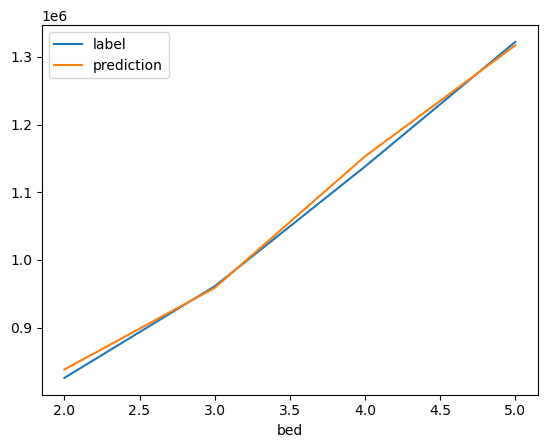

In [39]:
df = spark.sql("""select bed, 
    avg(prediction) as prediction, avg(label) as label 
    from predictions 
    group by bed
    having count(*) > 50
    order by bed""").toPandas()
ax = df.plot.line(x='bed', y='label', rot=0)
df.plot.line(x='bed', y='prediction', ax=ax, rot=0)

24/12/26 18:23:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

<AxesSubplot:xlabel='bath'>

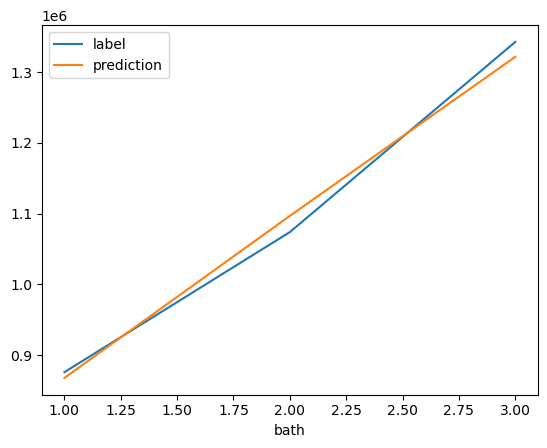

In [40]:
df = spark.sql("""select bath, 
    avg(prediction) as prediction, avg(label) as label 
    from predictions 
    group by bath
    having count(*) > 50
    order by bath""").toPandas()
ax = df.plot.line(x='bath', y='label', rot=0)
df.plot.line(x='bath', y='prediction', ax=ax, rot=0)

24/12/26 18:23:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

<AxesSubplot:xlabel='car'>

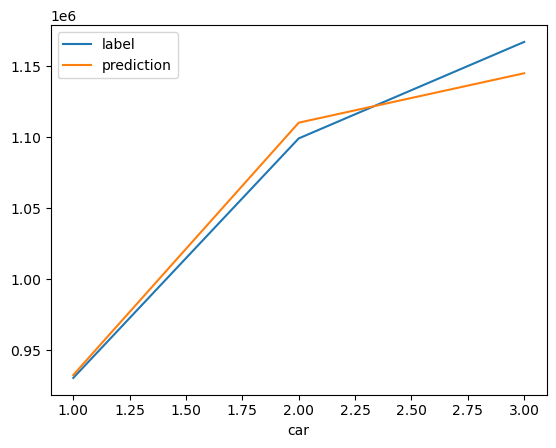

In [41]:
df = spark.sql("""select car, 
    avg(prediction) as prediction, avg(label) as label 
    from predictions 
    group by car
    having count(*) > 50
    order by car""").toPandas()
ax = df.plot.line(x='car', y='label', rot=0)
df.plot.line(x='car', y='prediction', ax=ax, rot=0)

24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

<AxesSubplot:xlabel='suburb_nr'>

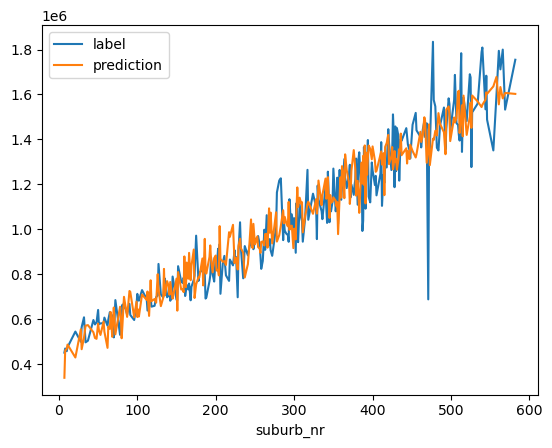

In [42]:
df = spark.sql("""select suburb_nr, 
    avg(prediction) as prediction, avg(label) as label 
    from predictions 
    group by suburb_nr
    having count(*) > 50
    order by suburb_nr""").toPandas()
ax = df.plot.line(x='suburb_nr', y='label', rot=0)
df.plot.line(x='suburb_nr', y='prediction', ax=ax, rot=0) 

24/12/26 18:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 18:23:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/26 1

<AxesSubplot:xlabel='propType_nr'>

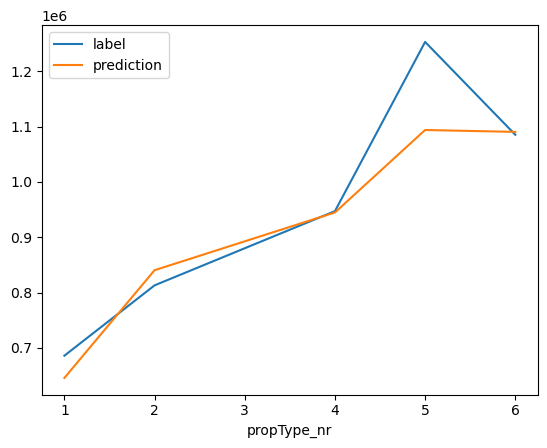

In [43]:
df = spark.sql("""select propType_nr, 
    avg(prediction) as prediction, avg(label) as label 
    from predictions 
    group by propType_nr
    having count(*) > 50
    order by propType_nr""").toPandas()
ax = df.plot.line(x='propType_nr', y='label', rot=0)
df.plot.line(x='propType_nr', y='prediction', ax=ax, rot=0) 

# Klasyfikacja 

Do oceny jadalności grzybów skorzystajmy z klasyfikatora opartego na algorytmie *Random Forest*.

## Zapoznanie się ze zbiorem danych
Na początek zaczytajmy nasze dane, a następnie trochę się im przyglądnijmy.

In [44]:
%%sh
wget https://jankiewicz.pl/bigdata/bigdata-sp/mushrooms.csv

--2024-12-26 18:23:42--  https://jankiewicz.pl/bigdata/bigdata-sp/mushrooms.csv
Resolving jankiewicz.pl (jankiewicz.pl)... 109.95.159.1
Connecting to jankiewicz.pl (jankiewicz.pl)|109.95.159.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374003 (365K) [application/octet-stream]
Saving to: ‘mushrooms.csv.2’

     0K .......... .......... .......... .......... .......... 13% 1.14M 0s
    50K .......... .......... .......... .......... .......... 27% 2.33M 0s
   100K .......... .......... .......... .......... .......... 41%  101M 0s
   150K .......... .......... .......... .......... .......... 54% 2.42M 0s
   200K .......... .......... .......... .......... .......... 68% 52.8M 0s
   250K .......... .......... .......... .......... .......... 82%  178M 0s
   300K .......... .......... .......... .......... .......... 95%  165M 0s
   350K .......... .....                                      100%  154M=0.09s

2024-12-26 18:23:42 (4.15 MB/s) - ‘mushrooms.csv.2

In [45]:
%%sh
# w przypadku korzystania z klastra Hadoop
hadoop fs -copyFromLocal -f mushrooms.csv

In [46]:
mushroomsDF = spark.read.format("csv")\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .load("mushrooms.csv")

In [47]:
mushroomsDF.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

In [48]:
mushroomsDF.describe().toPandas()

,summary,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,count,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
1,mean,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,stddev,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,min,e,b,f,b,f,a,a,c,b,...,f,b,b,p,n,n,e,b,a,d
4,max,p,x,y,y,t,y,f,w,n,...,y,y,y,p,y,t,p,y,y,w


Zobaczmy ile unikalnych wartości ma każda z cech 

In [49]:
from pyspark.sql.functions import approx_count_distinct

# val exprs = mushroomsDF.columns.map((_ -> "approx_count_distinct")).toMap
mushroomsDF.agg(approx_count_distinct("ring-number")).show()

24/12/26 18:23:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------------------------+
|approx_count_distinct(ring-number)|
+----------------------------------+
|                                 3|
+----------------------------------+



No ale chyba nie będziemy pisali ręcznie zapytania, z uwzględnieniem każdej kolumny...
Popatrz:
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.agg.html#pyspark.sql.GroupedData.agg

Argumentem metody `agg` może być obiekt `Dict`

In [50]:
mushroomsDF.agg({'class': 'approx_count_distinct',
                 'cap-shape': 'approx_count_distinct'}).show()

+--------------------------------+----------------------------+
|approx_count_distinct(cap-shape)|approx_count_distinct(class)|
+--------------------------------+----------------------------+
|                               6|                           2|
+--------------------------------+----------------------------+



In [51]:
# dla przykładu taki 

dict(map(
    lambda n: (n, "approx_count_distinct"),
    mushroomsDF.columns))

{'class': 'approx_count_distinct',
 'cap-shape': 'approx_count_distinct',
 'cap-surface': 'approx_count_distinct',
 'cap-color': 'approx_count_distinct',
 'bruises': 'approx_count_distinct',
 'odor': 'approx_count_distinct',
 'gill-attachment': 'approx_count_distinct',
 'gill-spacing': 'approx_count_distinct',
 'gill-size': 'approx_count_distinct',
 'gill-color': 'approx_count_distinct',
 'stalk-shape': 'approx_count_distinct',
 'stalk-root': 'approx_count_distinct',
 'stalk-surface-above-ring': 'approx_count_distinct',
 'stalk-surface-below-ring': 'approx_count_distinct',
 'stalk-color-above-ring': 'approx_count_distinct',
 'stalk-color-below-ring': 'approx_count_distinct',
 'veil-type': 'approx_count_distinct',
 'veil-color': 'approx_count_distinct',
 'ring-number': 'approx_count_distinct',
 'ring-type': 'approx_count_distinct',
 'spore-print-color': 'approx_count_distinct',
 'population': 'approx_count_distinct',
 'habitat': 'approx_count_distinct'}

In [52]:
exprs = dict(map(
    lambda n: (n, "approx_count_distinct"),
    mushroomsDF.columns))

mushroomsDF.agg(exprs).toPandas()

,approx_count_distinct(stalk-surface-above-ring),approx_count_distinct(veil-color),approx_count_distinct(cap-shape),approx_count_distinct(cap-surface),approx_count_distinct(stalk-color-above-ring),approx_count_distinct(gill-attachment),approx_count_distinct(population),approx_count_distinct(ring-type),approx_count_distinct(stalk-color-below-ring),approx_count_distinct(stalk-shape),...,approx_count_distinct(stalk-surface-below-ring),approx_count_distinct(gill-color),approx_count_distinct(habitat),approx_count_distinct(ring-number),approx_count_distinct(spore-print-color),approx_count_distinct(class),approx_count_distinct(cap-color),approx_count_distinct(stalk-root),approx_count_distinct(gill-size),approx_count_distinct(odor)
0,4,4,6,4,9,2,6,5,9,2,...,4,12,7,3,9,2,9,4,2,9


In [53]:
mushroomsDF.createOrReplaceTempView("mushroomsDF")

c,e,p
cap_color,,
b,48.0,120.0
c,32.0,12.0
e,624.0,876.0
g,1032.0,808.0
n,1264.0,1020.0
p,56.0,88.0
r,16.0,NaN
u,16.0,NaN
w,720.0,320.0


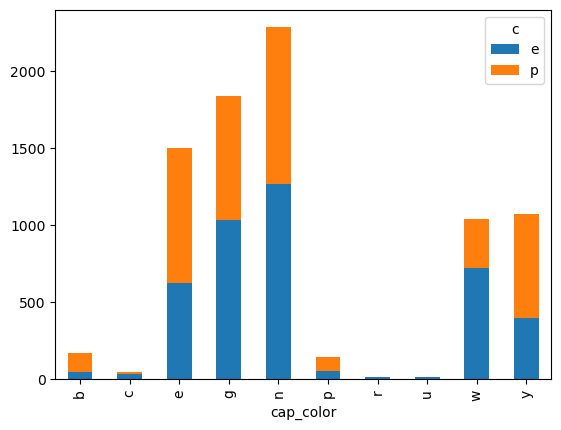

In [54]:
df = spark.sql("""select `cap-color` as cap_color, class as c, count(*) howmany
    from   mushroomsDF
    where   `cap-color` != 'nan'
    group by `cap-color`, class""").toPandas().pivot(index='cap_color', columns='c')['howmany']
df.plot.bar(stacked=True)
df

c,e,p
odor,,
a,400.0,NaN
c,NaN,192.0
f,NaN,2160.0
l,400.0,NaN
m,NaN,36.0
n,3408.0,120.0
p,NaN,256.0
s,NaN,576.0
y,NaN,576.0


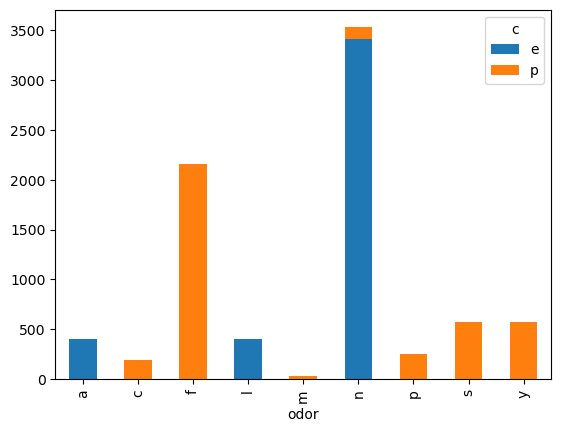

In [55]:
df = spark.sql("""select `odor` as odor, class as c, count(*) howmany
from   mushroomsDF
group by `odor`, class""").toPandas().pivot(index='odor', columns='c')['howmany']
df.plot.bar(stacked=True)
df

c,e,p
gill_color,,
b,NaN,1728.0
e,96.0,NaN
g,248.0,504.0
h,204.0,528.0
k,344.0,64.0
n,936.0,112.0
o,64.0,NaN
p,852.0,640.0
r,NaN,24.0


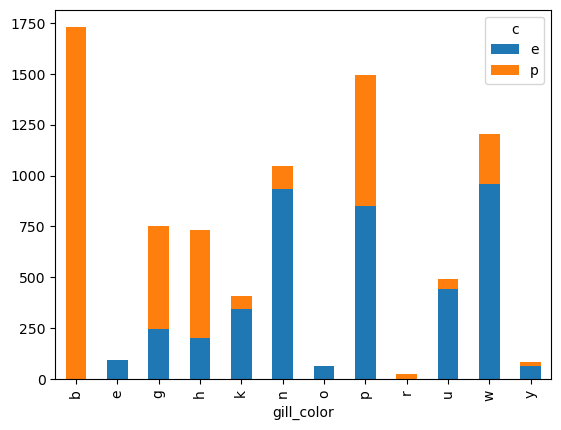

In [56]:
df = spark.sql("""select `gill-color` as gill_color, class as c, count(*) howmany
from   mushroomsDF
group by `gill-color`, class""").toPandas().pivot(index='gill_color', columns='c')['howmany']
df.plot.bar(stacked=True)
df

c,e,p
habitat,,
d,1880.0,1268.0
g,1408.0,740.0
l,240.0,592.0
m,256.0,36.0
p,136.0,1008.0
u,96.0,272.0
w,192.0,NaN


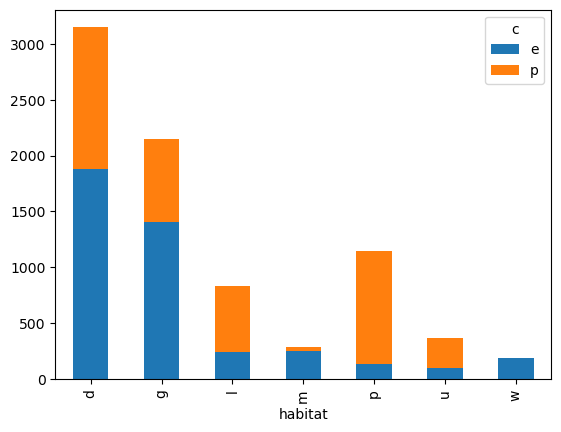

In [57]:
df = spark.sql("""select `habitat` as habitat, class as c, count(*) howmany
from   mushroomsDF
group by `habitat`, class""").toPandas().pivot(index='habitat', columns='c')['howmany']
df.plot.bar(stacked=True)
df


Ponownie, nasza analiza zależności pomiędzy danymi powinna być oczywiście bardziej dokładna. 
My się tym jednak nie będziemy zajmować teraz. Możesz to zrobić w późniejszym etapie w ramach poprawy tej procedury.

Teraz przejdźmy już bez dalszych opóźnień do naszej klasyfikacji za pomocą algorytmu *Random Forest*.

## Dostosowanie formatu danych
Obecny format naszego `DataFrame` nie bardzo pasuje do formatu oczekiwanego przez mechanizmy biblioteki `MLlib`. Zatem w kolejnych krokach dokonamy stosownych transformacji. Skorzystamy w tym celu z klasy `VectorAssembler`. 
Ponownie, przykład, który być może już gdzieś widziałeś:

```python
data = rawData.where("ibu is not null").\
              filter("style in ('American IPA','American Pale Ale (APA)','Kölsch')").\
              selectExpr("cast(ibu as int) ibu", 
                         "cast(abv*100 as float) abv",
                         "style as label")

assembler = VectorAssembler(
    inputCols=["ibu", "abv"],
    outputCol="features")

df = assembler.transform(data)
```

Kilka wskazówek:
- tym razem chcemy wykorzystać wszystkie atrybuty
- każdy z nich jest tekstowy (jedna litera), a musi być numeryczny - postaraj się je przekonwertować (możesz skorzystać z funkcji `ascii`), Zrób to podobnie jak wyliczana była unikalna liczba wystąpień. Nie będziemy przecież pisali tej samej funkcji naście razy.
- pamiętaj aby wskazać etykietę - musi być typu `double`
- poniżej oczekiwany wynik funkcji `printSchema()`

Patrz: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.select.html

***Zadanie 2***

In [58]:
from pyspark.sql.functions import col,expr

exprs = list(
    map(
        lambda cn: expr(f"cast(ascii(`{cn}`) as double) as `{cn}`"),
        mushroomsDF.columns[:-1]
    )
)

data = mushroomsDF.select(exprs).withColumnRenamed("class", "label")

data.printSchema()

root
 |-- label: double (nullable = true)
 |-- cap-shape: double (nullable = true)
 |-- cap-surface: double (nullable = true)
 |-- cap-color: double (nullable = true)
 |-- bruises: double (nullable = true)
 |-- odor: double (nullable = true)
 |-- gill-attachment: double (nullable = true)
 |-- gill-spacing: double (nullable = true)
 |-- gill-size: double (nullable = true)
 |-- gill-color: double (nullable = true)
 |-- stalk-shape: double (nullable = true)
 |-- stalk-root: double (nullable = true)
 |-- stalk-surface-above-ring: double (nullable = true)
 |-- stalk-surface-below-ring: double (nullable = true)
 |-- stalk-color-above-ring: double (nullable = true)
 |-- stalk-color-below-ring: double (nullable = true)
 |-- veil-type: double (nullable = true)
 |-- veil-color: double (nullable = true)
 |-- ring-number: double (nullable = true)
 |-- ring-type: double (nullable = true)
 |-- spore-print-color: double (nullable = true)
 |-- population: double (nullable = true)



```
root
 |-- label: double (nullable = true)
 |-- cap-shape: double (nullable = true)
 |-- cap-surface: double (nullable = true)
 |-- cap-color: double (nullable = true)
 |-- bruises: double (nullable = true)
 |-- odor: double (nullable = true)
 |-- gill-attachment: double (nullable = true)
 |-- gill-spacing: double (nullable = true)
 |-- gill-size: double (nullable = true)
 |-- gill-color: double (nullable = true)
 |-- stalk-shape: double (nullable = true)
 |-- stalk-root: double (nullable = true)
 |-- stalk-surface-above-ring: double (nullable = true)
 |-- stalk-surface-below-ring: double (nullable = true)
 |-- stalk-color-above-ring: double (nullable = true)
 |-- stalk-color-below-ring: double (nullable = true)
 |-- veil-type: double (nullable = true)
 |-- veil-color: double (nullable = true)
 |-- ring-number: double (nullable = true)
 |-- ring-type: double (nullable = true)
 |-- spore-print-color: double (nullable = true)
 |-- population: double (nullable = true)
 |-- habitat: double (nullable = true)
 ```

In [59]:
from pyspark.ml.feature import VectorAssembler

features = list(
    filter(
        lambda e: e != "label",
        data.columns
    )
)

assembler = VectorAssembler(\
    inputCols=features,\
    outputCol="features")

mushroomsLibSVMDF = assembler.transform(data)
mushroomsLibSVMDF.printSchema()

mushroomsLibSVMDF.take(1)

root
 |-- label: double (nullable = true)
 |-- cap-shape: double (nullable = true)
 |-- cap-surface: double (nullable = true)
 |-- cap-color: double (nullable = true)
 |-- bruises: double (nullable = true)
 |-- odor: double (nullable = true)
 |-- gill-attachment: double (nullable = true)
 |-- gill-spacing: double (nullable = true)
 |-- gill-size: double (nullable = true)
 |-- gill-color: double (nullable = true)
 |-- stalk-shape: double (nullable = true)
 |-- stalk-root: double (nullable = true)
 |-- stalk-surface-above-ring: double (nullable = true)
 |-- stalk-surface-below-ring: double (nullable = true)
 |-- stalk-color-above-ring: double (nullable = true)
 |-- stalk-color-below-ring: double (nullable = true)
 |-- veil-type: double (nullable = true)
 |-- veil-color: double (nullable = true)
 |-- ring-number: double (nullable = true)
 |-- ring-type: double (nullable = true)
 |-- spore-print-color: double (nullable = true)
 |-- population: double (nullable = true)
 |-- features: vector

[Row(label=112.0, cap-shape=120.0, cap-surface=115.0, cap-color=110.0, bruises=116.0, odor=112.0, gill-attachment=102.0, gill-spacing=99.0, gill-size=110.0, gill-color=107.0, stalk-shape=101.0, stalk-root=101.0, stalk-surface-above-ring=115.0, stalk-surface-below-ring=115.0, stalk-color-above-ring=119.0, stalk-color-below-ring=119.0, veil-type=112.0, veil-color=119.0, ring-number=111.0, ring-type=112.0, spore-print-color=107.0, population=115.0, features=DenseVector([120.0, 115.0, 110.0, 116.0, 112.0, 102.0, 99.0, 110.0, 107.0, 101.0, 101.0, 115.0, 115.0, 119.0, 119.0, 112.0, 119.0, 111.0, 112.0, 107.0, 115.0]))]

Załóżmy, że tym razem potrzebujemy dokonać tylko jednorazowo takiego przetworzenia. Nie będziemy zatem przechowywali uzyskanego w tej chwili formatu danych i na dalszym etapie będziemy przetwarzać po prostu `DataFrame` *mushroomsLibSVMDF* tylko uzupełniony o `features` i `label`

## Wyliczenie modelu 

Podzielmy nasz zbiór na zbiór uczący i testowy

In [60]:
(trainingDF, testDF) = mushroomsLibSVMDF.randomSplit([0.7, 0.3], seed = 1234)

Indeksowanie etykiet i cech dla całego zbioru danych

Uzupełnij brakujące fragmenty, skorzystaj z materiałów wykładowych lub 

https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

***Zadanie 3***

In [61]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Indeksowanie etykiet dla całego zbioru danych
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(mushroomsLibSVMDF)

# Automatyczne indeksowanie cech
# Cechy powyżej 15 wartości będą traktowane jako ciągłe
featureIndexer = \
    VectorIndexer(inputCol="features", 
                  outputCol="indexedFeatures", 
                  maxCategories=15).fit(mushroomsLibSVMDF)

In [62]:
# Tworzymy definicję modelu
rf = RandomForestClassifier(labelCol="indexedLabel", 
                            featuresCol="indexedFeatures", 
                            numTrees=10)

# Definiujemy konwerter poindeksowanych etykiet na ich oryginalne wartości
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Łączymy: indeksowanie etykiet, indeksowanie cech, definicję naszego modelu
# i konwerter etykiet w jeden Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [63]:
# Uruchamiamy całość - w tym trenowanie modelu
model = pipeline.fit(trainingDF)

## Predykcja i ewaluacja

Wyliczmy predykcje cen dla testowego zbioru danych

***Zadanie 4***

In [64]:
# wprowadź w tym miejscu swoje rozwiązanie
predictions = model.transform(testDF)

In [65]:
predictions.select("predictedLabel", "label", "features").show(5)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|         101.0|101.0|[98.0,102.0,103.0...|
|         101.0|101.0|[98.0,102.0,103.0...|
|         101.0|101.0|[98.0,102.0,103.0...|
|         101.0|101.0|[98.0,102.0,103.0...|
|         101.0|101.0|[98.0,102.0,119.0...|
+--------------+-----+--------------------+
only showing top 5 rows



 
Wygląda to całkiem dobrze ale podejdźmy do tego sprawdzenia profesjonalnie 

In [66]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Ewaluacja oceny i wyznaczenie błędu trafności
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Błąd trafności = {(1.0 - accuracy)}")

Błąd trafności = 0.0033514872224549297


To co, chyba możemy iść na grzyby :) 

Zobaczmy tylko jak to wszystko działa. Czyli wydrukujmy sobie atlas grzybów.

In [67]:
rfModel = model.stages[2]
print(f"Definicja modelu:\n {rfModel.toDebugString}")

Definicja modelu:
 RandomForestClassificationModel: uid=RandomForestClassifier_c9af9a53203c, numTrees=10, numClasses=2, numFeatures=21
  Tree 0 (weight 1.0):
    If (feature 12 in {0.0,2.0,3.0})
     If (feature 7 in {0.0})
      If (feature 13 in {2.0,3.0,4.0,5.0,6.0})
       Predict: 0.0
      Else (feature 13 not in {2.0,3.0,4.0,5.0,6.0})
       If (feature 10 in {0.0,2.0,3.0,4.0})
        If (feature 14 in {2.0,7.0})
         Predict: 0.0
        Else (feature 14 not in {2.0,7.0})
         Predict: 1.0
       Else (feature 10 not in {0.0,2.0,3.0,4.0})
        If (feature 19 in {2.0,3.0,7.0})
         Predict: 0.0
        Else (feature 19 not in {2.0,3.0,7.0})
         Predict: 1.0
     Else (feature 7 not in {0.0})
      If (feature 10 in {1.0,2.0,3.0})
       If (feature 1 in {0.0,1.0})
        If (feature 4 in {0.0,3.0,5.0})
         Predict: 0.0
        Else (feature 4 not in {0.0,3.0,5.0})
         Predict: 1.0
       Else (feature 1 not in {0.0,1.0})
        If (feature 6 in {